# Structure functions : implementation and challenges

In this notebook, we investigate the impact parameters (period, amplitude, magnitude, error) and binning has on SF

## 1. Initialization : 
libraries and paths

In [1]:
#Libraries

import sys
import os

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from   scipy.signal      import savgol_filter
from   itertools         import product
from   tqdm              import tqdm

sys.path.append('../../Benchmark_QM/Packages')
sys.path.append('../../GaiaDR3_study/Packages')


from   Handy             import get_files_paths
from   Handy             import amp_595

import StructureFunction as     SF

In [2]:
#Paths
path_init   = os.path.expanduser('~')
path        = get_files_paths(path_init + '/M2/Codes/GaiaDR3_study/paths.txt')
filepath    = path['synthetic_dr3']
path_obs_w  = path['dr3_obs_window']

## 2. Synthetic light curves

- Get Gaia DR3 sampling from one of the catalog's source
- Define a grid of parameters
- Create a bunch of light curves with a periodic signal from the grid

The parameters are : 
- Period $P$,
- Amplitude $A$, 
- median magnitude $mag_{med}$,
- Gaussian noise.

The magnitude at time t is :
\begin{equation}
mag = mag_{med} + \frac{A}{2} \sin{(2 \pi t/P)} + noise
\end{equation}

In [3]:
# Get Gaia sampling

ID        = 761
band      = 'G'
path_star = path['gaia_data'] + f'/Nemesis_{ID}.csv'
star      = pd.read_csv(path_star, delimiter='\t')
times     = np.array(star[f'Time{band}'])
times     = times[~np.isnan(times)]

In [42]:
# Parameter grid
periods   = [0.5, 3, 13, 23, 101, 0.45]  #days
amps      = [0.2, 0.7, 1]          #mag
medmags   = [10, 12, 15]            #mag
sigs      = [0.001, 0.01, 0.03]

param_grid = {'periods' : periods, 'amps' : amps, 'medmags' : medmags, 'sigs' : sigs}

#Colors definition
colors  = ['cornflowerblue', 'indianred', 'midnightblue','darkred', 'mediumslateblue', 'orange']

In [43]:
#Synthetic light curve
def sine(period, amp, med_mag, sig, times) :
    noise    = np.random.normal(0, sig, len(times))
    mag      = med_mag + amp/2 * np.sin(2 * np.pi * (times - min(times))/period) + noise
    return mag

In [44]:
# make all the lc
parameter_combinations = [(p, a, m, s) \
                          for p in periods for a in amps for m in medmags for s in sigs]
lc_dict = {}

for params in parameter_combinations:
    
    period, amp, med_mag, sig = params
    
    mag_synt = sine(period, amp, med_mag, sig, times)
    
    # Store the light curve in the dictionary with a label based on parameters
    label = f'period={period}_amp={amp}_medmag={med_mag}_sig={sig}'
    lc_dict[label] = {'time': times, 'mag': mag_synt}


## 3. SF 
Computing all the structure functions, using the formula from Roelens+17 :

\begin{equation}
SF(\tau_1, \tau_2) = \frac{1}{p(\tau_1, \tau_2)} \sum{(mag_i - mag_j)^2}
\end{equation}

In [45]:
#Compute the SF
sf_dict = {}

for params in tqdm(parameter_combinations):
    
    period, amp, med_mag, sig = params
    label = f'period={period}_amp={amp}_medmag={med_mag}_sig={sig}'
    mag   = lc_dict[label]['mag']

    sf, t_log, it   = SF.structure_function_slow(np.array(mag), np.array(times-min(times)),\
                                                   num_bins = 50)
    ts              = SF.find_timescale(sf, t_log)
    sf_dict[label]  = {'sf': sf, 't_log': t_log, 'ts': ts}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 562.04it/s]


## 4. Show impact of parameters on SF

In [46]:
def plot_light_curves_and_sf(loop, fix_param, lc_dict, sf_dict, colors, print_message=True):
    '''
    This function :
    - takes all the light curves and corresponding structure functions, 
    - extract all the ones with the parameters fix_param and one varying parameter loop
    - makes a plot with said curves 
    
    Args : 
    - loop : (str) parameter that has to vary. Can be 'period', 'amp', 'medmag', 'sig'
    - fix_param : (array) parameters fixed, of the form [period, amp, medmag, sig]. 
    Whatever parameter specified in loop should be np.nan
    - lc_dict, sf_dict : lc and sf dictionary containing data for the full grid
    
    Returns :
    - fig, ax
    '''
    
    keys        = list(lc_dict.keys())
    params_loop = param_grid[loop + 's']
    loc_loop    = np.where(np.isnan(fix_param))[0][0]
    
    fig, ax     = plt.subplots(2, 1, figsize=(12, 10), \
                               gridspec_kw={'height_ratios': [2, 3], 'hspace': 0.3})
    
    ax[0].set_title(f'Light Curves for period={fix_param[0]}, amp={fix_param[1]}, medmag={fix_param[2]}, sig={fix_param[3]}')
    ax[1].set_title(f'Structure Functions for period={fix_param[0]}, amp={fix_param[1]}, medmag={fix_param[2]}, sig={fix_param[3]}')
    
    for i, param_loop in enumerate(params_loop) :
        fix_param[loc_loop] = param_loop
        key_loop            = f'period={fix_param[0]}_amp={fix_param[1]}_medmag={fix_param[2]}_sig={fix_param[3]}'
        key                 = keys[np.where(np.array(keys)==key_loop)[0][0]]
        lc, sf              = lc_dict[key], sf_dict[key]
        
        # Plot light curves
        print(lc['mag'][0])
        ax[0].scatter(lc['time'], lc['mag'], label=f'{loop}={param_loop}',\
                      c=colors[i])
        ax[0].plot(lc['time'], lc['mag'], label=f'{loop}={param_loop}',\
                      c=colors[i], alpha = .2)
        #if param_loop == 0.5 :
        #    print(lc['time'], lc['mag'])
        
        # Plot structure functions
        ax[1].scatter(sf['t_log'], sf['sf'], label=f'{loop}={param_loop}',\
                      c=colors[i])
        ax[1].plot(sf['t_log'], sf['sf'], linestyle='--', alpha=0.5,\
                  c=colors[i])
        
        # Add vertical lines at the period parameter
        ax[1].axvline(x=fix_param[0], color=colors[i], alpha=0.7)
    
    ax[0].set_xlabel('Time (days)')
    ax[0].set_ylabel('Magnitude')
    ax[0].legend(loc='lower right')

    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Time (days)')
    ax[1].set_ylabel('Structure Function')
    ax[1].legend(loc='lower right')

   
    return fig, ax

### 4.1 Periods

12.001231511422565
11.99803344646011
12.001752948506185
11.999387786684565
12.001293520510785
11.99958333980181


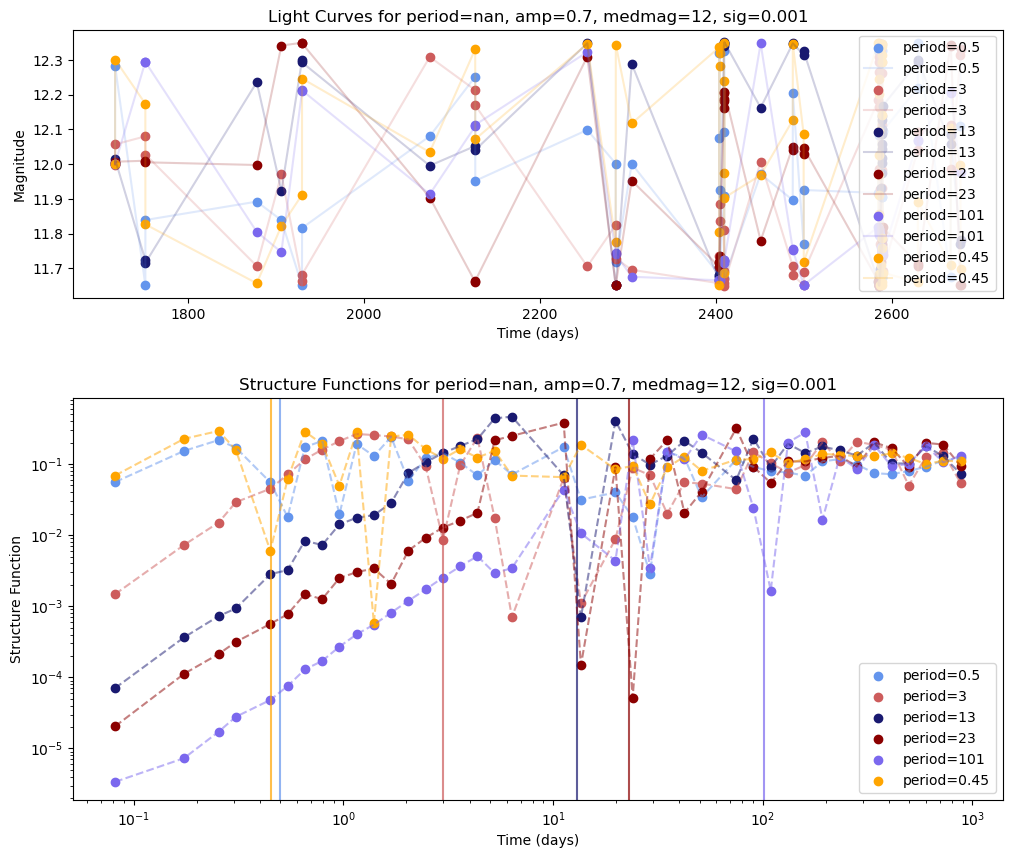

In [47]:
fixed_param = [np.nan, amps[1], medmags[1], sigs[0]] 
fig, ax     = plot_light_curves_and_sf('period', fixed_param, lc_dict, sf_dict, colors)

### 4.2 Amplitudes

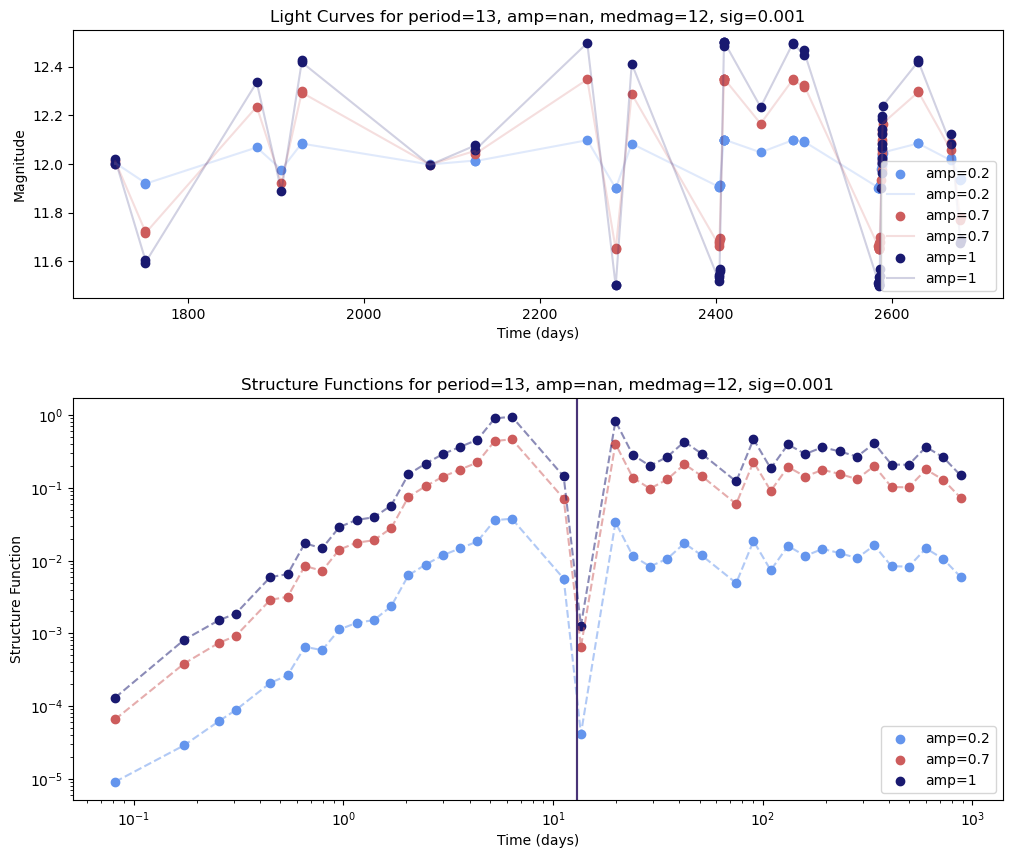

In [10]:
fixed_param = [periods[2], np.nan, medmags[1], sigs[0]] 
fig, ax     = plot_light_curves_and_sf('amp', fixed_param, lc_dict, sf_dict, colors)

### 4.3 Median magnitudes

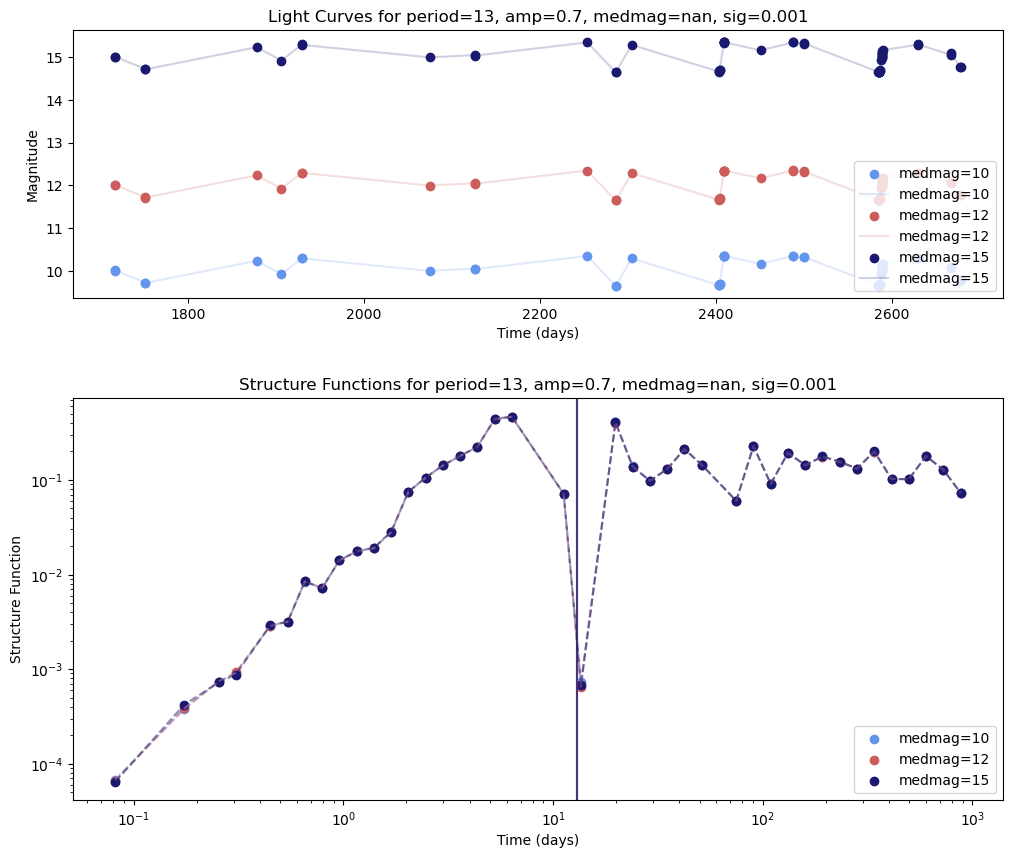

In [11]:
fixed_param = [periods[2], amps[1], np.nan, sigs[0]] 
fig, ax     = plot_light_curves_and_sf('medmag', fixed_param, lc_dict, sf_dict, colors)

### 4.4 Sigmas

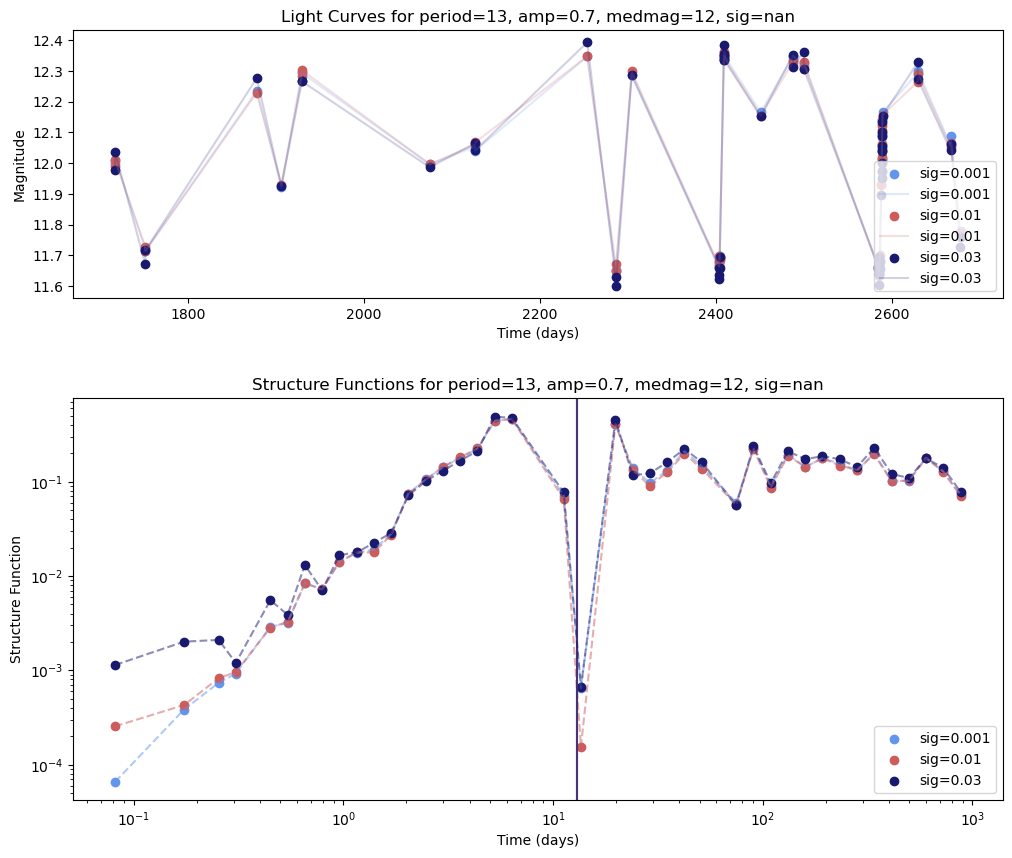

In [12]:
fixed_param = [periods[2], amps[1], medmags[1], np.nan] 
fig, ax     = plot_light_curves_and_sf('sig', fixed_param, lc_dict, sf_dict, colors)

## 5. Show impact of number of bins

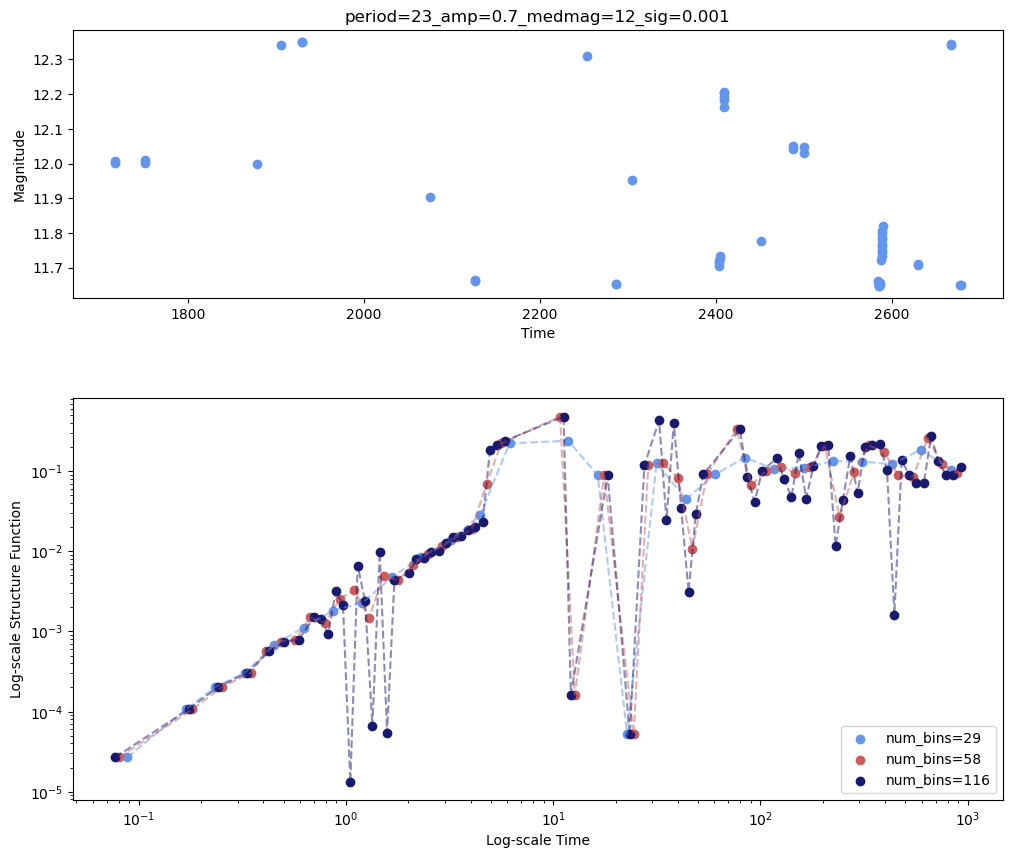

In [13]:
num_bins_list             = [int(0.5*len(times)), len(times), 2*len(times)]

fig, ax = plt.subplots(2, 1, figsize=(12, 10),\
          gridspec_kw={'height_ratios': [2, 3], 'hspace': 0.3})


#Light curve
period, amp, med_mag, sig = periods[3], amps[1], medmags[1], sigs[0]
label = f'period={period}_amp={amp}_medmag={med_mag}_sig={sig}'
mag   = lc_dict[label]['mag']

#plot lc
ax[0].scatter(times, mag, c=colors[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Magnitude')
ax[0].set_title(label)

#SF with num_bins varying
for i, num_bins in enumerate(num_bins_list) :

    sf, t_log, it   = SF.structure_function_slow(np.array(mag), np.array(times-min(times)),\
                                                   num_bins = num_bins)
    ts              = SF.find_timescale(sf, t_log)
    
    # Plot sf
    ax[1].scatter(t_log, sf, label=f'num_bins={num_bins}', c=colors[i])
    ax[1].plot(t_log, sf, linestyle='--', c=colors[i], alpha=0.5)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Log-scale Time')
ax[1].set_ylabel('Log-scale Structure Function')
ax[1].legend(loc='lower right')

plt.show()

## 6. Set a threshold for number of pairs per time bin

The idea is to set a minimum threshold for the numbers of pairs at a given tau needed to compute SF(tau). If the threshold is not reached with the logarithmic time-bin, we increase the size of the bin until it is the case.

Consequently, some of the time bins might overlap. 

If no pair at all is found, the threshold is not applied to avoid overfitting.

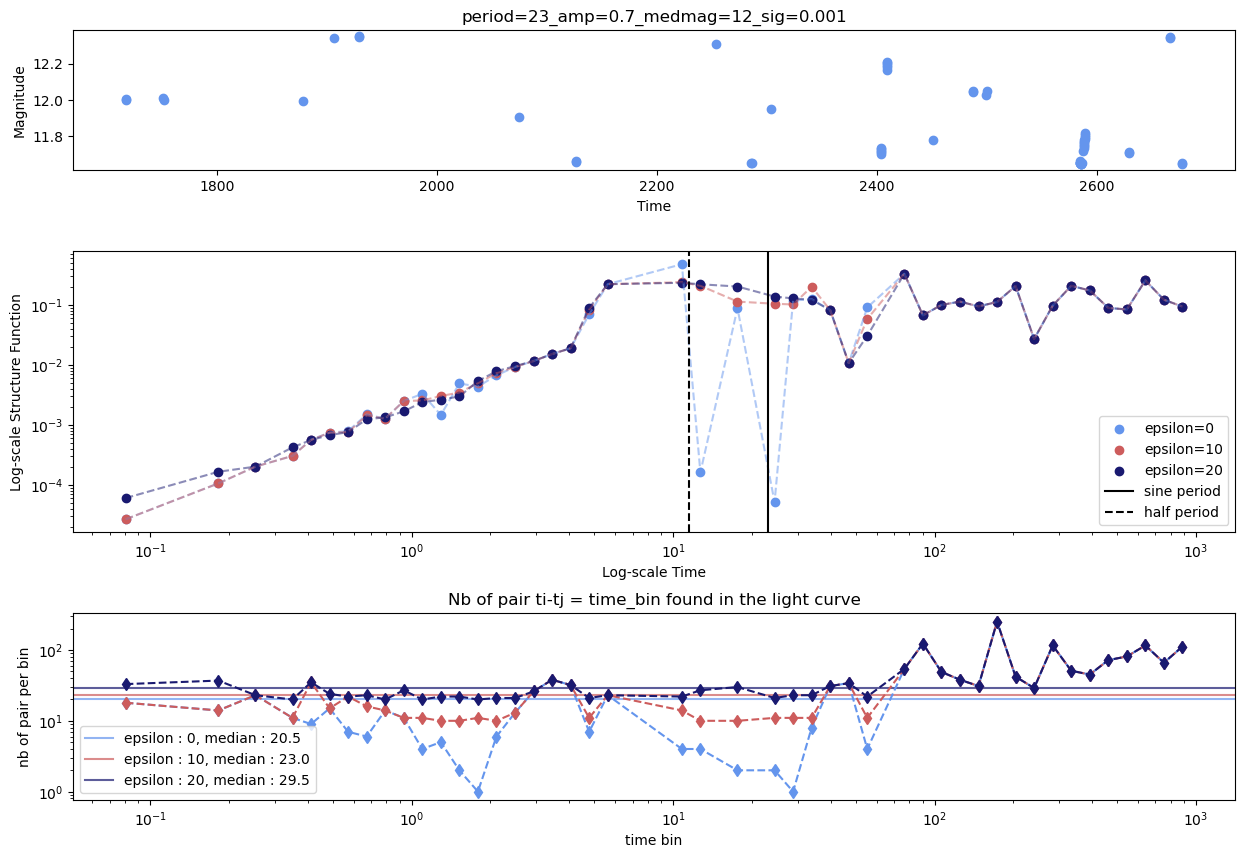

In [14]:
epsilon_list = [0, 10, 20]

fig, ax = plt.subplots(3, 1, figsize=(15, 10),\
          gridspec_kw={'height_ratios': [1.5, 3, 2], 'hspace': 0.4})


#Light curve
period, amp, med_mag, sig = periods[3], amps[1], medmags[1], sigs[0]
label = f'period={period}_amp={amp}_medmag={med_mag}_sig={sig}'
mag   = lc_dict[label]['mag']

#plot lc
ax[0].scatter(times, mag, c=colors[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Magnitude')
ax[0].set_title(label)

#SF with num_bins varying
for i, epsilon in enumerate(epsilon_list) :

    sf, t_log, it   = SF.structure_function_slow(np.array(mag), np.array(times-min(times)),\
                                                   num_bins = len(times), epsilon = epsilon)
    ts              = SF.find_timescale(sf, t_log)
    
    # Plot sf
    ax[1].scatter(t_log, sf, label=f'epsilon={epsilon}', c=colors[i])
    ax[1].plot(t_log, sf, linestyle='--', c=colors[i], alpha=0.5)
    #ax[1].axvline(2*ts, label = f'ts = {np.round(2*ts, 2)} days', c = colors[i])
    
    #plot nb of pairs per bin
    ax[2].plot(t_log, it, c =colors[i], marker = 'd', ls = '--')
    ax[2].axhline(np.median(it), c = colors[i], alpha = .7, zorder = 0,\
                  label = f'epsilon : {epsilon}, median : {np.round(np.median(it), 2)}')

ax[1].axvline(period, c = 'black', label = 'sine period')
ax[1].axvline(period/2, c = 'black', ls = '--', label = 'half period')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Log-scale Time')
ax[1].set_ylabel('Log-scale Structure Function')
ax[1].legend(loc='lower right')

#Nb of pairs found for each
ax[2].set_xlabel('time bin')
ax[2].set_ylabel('nb of pair per bin')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Nb of pair ti-tj = time_bin found in the light curve')
ax[2].legend()

plt.show()

1717.102578 12.002160004090566
1717.102578 12.001338428667022


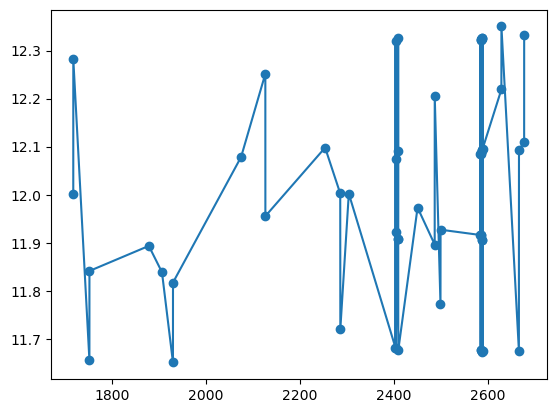

In [15]:
period, amp, med_mag, sig = [0.5, 0.7, 12, 0.001]
time_even = np.arange(min(times), max(times), 1)
    
mag_synt = sine(period, amp, med_mag, sig, times)
mag_even = sine(period, amp, med_mag, sig, time_even)
plt.plot(times, mag_synt)
plt.scatter(times, mag_synt)
print(min(time_even), mag_even[0])
print(min(times), mag_synt[0])

In [20]:
print(times)

[1717.102578 1717.176592 1751.490585 1751.564598 1878.077661 1906.064287
 1929.484625 1929.558626 2074.620778 2126.289066 2126.363078 2253.625283
 2285.852154 2286.028295 2304.103034 2403.443667 2403.619838 2403.693871
 2403.870018 2403.94386  2408.873379 2409.12353  2409.197591 2409.373741
 2409.447754 2450.596193 2487.078648 2487.152649 2499.409236 2499.585434
 2584.371713 2584.621865 2584.695868 2584.871987 2584.946057 2585.122163
 2585.196137 2585.372354 2585.622454 2585.696455 2585.946599 2587.697591
 2587.947734 2588.123878 2588.197879 2588.374023 2588.447976 2588.624141
 2588.698164 2588.874318 2588.94832  2589.124468 2629.156119 2629.230091
 2666.447969 2666.624112 2677.628287 2677.70231 ]
